# Section 4.5.1 Application to kernel spectral clustering

This page contains simulations in Section 4.5.1.

## Contents

    - Non-informative eigenvector of $L$
    - Separation with covariance trace information
    - Implementation on MNIST data
    - $\alpha$-$\beta$ distance kernel on Gaussian data
    - $\alpha$-$\beta$ distance kernel on EEG data
    - FUNCTIONS
    - Performance of spectral clustering with properly scaling kernels

## Non-informative eigenvector of $L$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse.linalg
import sklearn.cluster
import scipy.io
import itertools
from tensorflow.keras.datasets import mnist
pi = np.pi

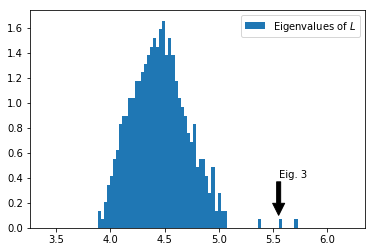

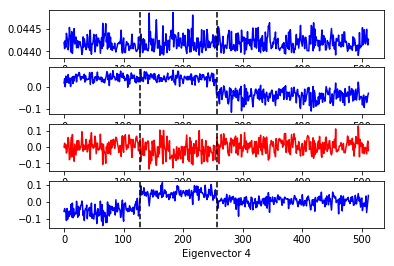

In [2]:
coeff = 4
p = 512*coeff
n = 128*coeff

cs = [1/4, 1/4, 1/2]
k = len(cs) # number of classes

test_case = 'means'

if test_case == 'means':
    means = lambda i : np.concatenate([np.zeros(i-1),[1],np.zeros(p-i)])*5
    covs  = lambda i : np.eye(p)

if test_case == 'var':
    means = lambda i : np.zeros(p)
    covs  = lambda i : np.eye(p)*(1+(-1)**(i)/np.sqrt(p)*5)

if test_case == 'orth':
    means = lambda i : np.zeros(p)
    covs  = lambda i : scipy.linalg.toeplitz([(4**(i-1)/10)**j for j in range(p)])

if test_case == 'mixed':
    means = lambda i : np.concatente([-np.ones(p/2),np.ones(p/2)])/np.sqrt(p)
    covs  = lambda i : np.eye(p)*(1+(i-1)/np.sqrt(p)*10)

np.random.seed(1004)
X=np.zeros( (p,n) )
for i in range(k):
    X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1]*n))]=scipy.linalg.sqrtm(covs(i+1))@np.random.randn(p,int(cs[i]*n))+means(i+1).reshape(p,1)
    
XX = X.T@X

tau = 2
f = lambda t : 4*(t-tau)**2-(t-tau)+4
K = f((-2*XX+np.diag(XX).reshape(n,1)+np.diag(XX).reshape(1,n))/p)

D = np.diag(np.sum(K,axis=0))
L = n*np.diag(1/np.sqrt(np.diag(D)))@K@np.diag(1/np.sqrt(np.diag(D)))

eigs_L,V = np.linalg.eigh(L)
ind = np.argsort(eigs_L)
eigs_L = eigs_L[ind]
V = V[:,ind]

edges = np.linspace(np.min(eigs_L[:-1])-.5,np.max(eigs_L[:-1])+.5,100)

plt.figure()
plt.hist(eigs_L[:-1],bins=edges,weights=1/(n-1)/(edges[1]-edges[0])*np.ones(n-1),label=r'Eigenvalues of $L$')
plt.annotate('Eig. 3',xy=(5.55,.1),xytext=(5.55,.4), arrowprops=dict(facecolor='black'))
plt.legend()

plt.figure()
for i in range(1,5):    
    plt.subplot(4,1,i)
    if i == 3:
        plt.plot(V[:,n-i],'r')
        plt.axvline(x=n*cs[0],ymin=-1,ymax=1,c='k',ls='--')
        plt.axvline(x=n*(cs[0]+cs[1]),ymin=-1,ymax=1,c='k',ls='--')
    else:
        plt.plot(V[:,n-i],'b')
        plt.axvline(x=n*cs[0],ymin=-1,ymax=1,c='k',ls='--')
        plt.axvline(x=n*(cs[0]+cs[1]),ymin=-1,ymax=1,c='k',ls='--')

    plt.xlabel('Eigenvector '+str(i))

## Separation with covariance trace information

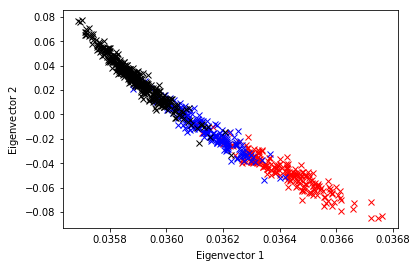

In [3]:
coeff = 6
p = 512*coeff
n = 128*coeff

cs = [1/4, 1/4, 1/2]
k = len(cs) # number of classes

test_case = 'var'

if test_case == 'means':
    means = lambda i : np.concatenate([np.zeros(i-1),[1],np.zeros(p-i)])*5
    covs  = lambda i : np.eye(p)

if test_case == 'var':
    means = lambda i : np.zeros(p)
    covs  = lambda i : np.eye(p)*(1+4*(i-1)/np.sqrt(p))

if test_case == 'orth':
    means = lambda i : np.zeros(p)
    covs  = lambda i : scipy.linalg.toeplitz([(4**(i-1)/10)**j for j in range(p)])

if test_case == 'mixed':
    means = lambda i : np.concatente([-np.ones(p/2),np.ones(p/2)])/np.sqrt(p)
    covs  = lambda i : np.eye(p)*(1+(i-1)/np.sqrt(p)*10)
    
np.random.seed(928)
X=np.zeros( (p,n) )
for i in range(k):
    X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1]*n))]=scipy.linalg.sqrtm(covs(i+1))@np.random.randn(p,int(cs[i]*n))+means(i+1).reshape(p,1)
    
XX = X.T@X

tau = 0
for a in range(k):
    tau += 2*cs[a]*np.trace(covs(a+1))/p

f = lambda t : 1.5*(t-tau)**2-(t-tau)+5
K = f((-2*XX+np.diag(XX).reshape(n,1)+np.diag(XX).reshape(1,n))/p)

D = np.diag(np.sum(K,axis=0))
L = n*np.diag(1/np.sqrt(np.diag(D)))@K@np.diag(1/np.sqrt(np.diag(D)))

eigs_L,V = np.linalg.eigh(L)
ind = np.argsort(eigs_L)
eigs_L = eigs_L[ind]
V = V[:,ind]

v1 = V[:,-1]
v2 = V[:,-2]
v3 = V[:,-3]

if test_case == 'means':
    plt.figure()
    plt.plot(v2[:int(n*cs[0])],v3[:int(n*cs[0])],'rx')
    plt.plot(v2[int(n*cs[0]):-int(n*cs[2])],v3[int(n*cs[0]):-int(n*cs[2])],'bx')
    plt.plot(v2[int(n-n*cs[2]):],v3[int(n-n*cs[2]):],'kx')
    plt.xlabel(r'Eigenvector $2$')
    plt.ylabel(r'Eigenvector $3$')

if test_case == 'var':
    plt.figure()
    plt.plot(v1[:int(n*cs[0])],v2[:int(n*cs[0])],'rx')
    plt.plot(v1[int(n*cs[0]):-int(n*cs[2])],v2[int(n*cs[0]):-int(n*cs[2])],'bx')
    plt.plot(v1[int(n-n*cs[2]):],v2[int(n-n*cs[2]):],'kx')
    plt.xlabel(r'Eigenvector $1$')
    plt.ylabel(r'Eigenvector $2$')

## Implementation on MNIST data

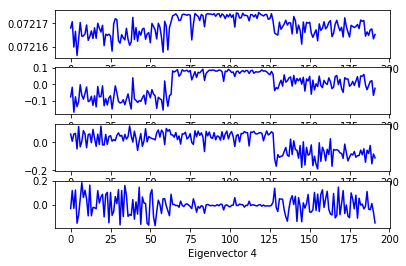

In [4]:
n = 192

cs = [1/3,1/3,1/3]
k = len(cs) # number of classes

(init_data, init_labels), _ = mnist.load_data()

idx_init_labels = np.argsort(np.array(init_labels))
    
labels = init_labels[idx_init_labels]
init_data = init_data[idx_init_labels,:,:]
data = np.transpose(init_data.reshape(np.shape(init_data)[0],np.shape(init_data)[1]*np.shape(init_data)[2]))
init_n,p=np.shape(data)[1],np.shape(data)[0]

selected_labels=[0,1,2] # selected digits: must be of size 'k'

# Data preprocessing
data = data/data.max()
mean_data=np.mean(data,axis=1).reshape(len(data),1)

norm2_data=0
for i in range(init_n):
    norm2_data+=1/init_n*np.linalg.norm(data[:,i]-mean_data)**2

data=np.mat((data-mean_data)/np.sqrt(norm2_data)*np.sqrt(p))

selected_data = []

for i in range(len(selected_labels)):
    selected_data.append(data[:,[ x for x in range(init_n) if labels[x]==selected_labels[i] ] ])

X= np.zeros((p,n))
for i in range(k): # random data picking
    data = selected_data[i][:,np.random.permutation(np.shape(selected_data[i])[1])]
    X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=data[:,:int(n*cs[i])] 
    
XX=X.T@X
K=np.exp(-1/2/p*(-2*XX+np.diag(XX).reshape(n,1)+np.diag(XX).reshape(1,n)))

D = np.diag(np.sum(K,axis=0))
L = n*np.diag(1/np.sqrt(np.diag(D)))@K@np.diag(1/np.sqrt(np.diag(D)))

eigs_L,V = np.linalg.eigh(L)
ind = np.argsort(eigs_L)
eigs_L = eigs_L[ind]
V = V[:,ind]

plt.figure()
for i in range(1,5):
    plt.subplot(4,1,i)
    plt.plot(V[:,n-i],'b')
    plt.xlabel('Eigenvector '+str(i))

## $\alpha$-$\beta$ distance kernel on Gaussian data

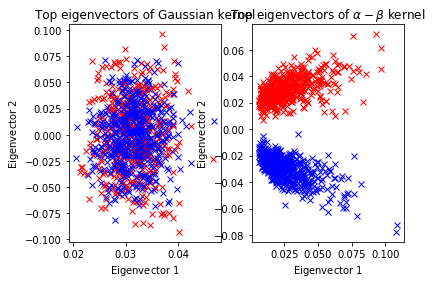

In [5]:
coeff = 1
p = 400*coeff
n = 1000*coeff

cs = [1/2,1/2]
k = len(cs) # number of classes

Z = []
for i in range(k):
    Z.append(np.random.randn(p,p//2))

means = lambda i : np.zeros(p)
covs  = lambda i : .1*np.eye(p) + 2*Z[i]@Z[i].T/p

covs_mean = cs[0]*covs(0) + cs[1]*covs(1)
tau = 2*np.trace(covs_mean)/p


X = np.zeros((p,n))
for i in range(k):
    X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1]*n))]=np.real(scipy.linalg.sqrtm(covs(i)))@np.random.randn(p,int(cs[i]*n))+means(i).reshape(p,1)

XX = X.T@X

K1= np.exp(-(-2*XX+np.diag(XX).reshape(n,1)+np.diag(XX).reshape(1,n))/p)
K2 =((-2*XX+np.diag(XX).reshape(n,1)+np.diag(XX).reshape(1,n))/p-2)**2


eigs_K1,V1 = np.linalg.eigh(K1)
eigs_K2,V2 = np.linalg.eigh(K2)
ind = np.argsort(eigs_K1)
V1 = V1[:,ind]
ind = np.argsort(eigs_K2)
V2 = V2[:,ind]

v1_1 = V1[:,-1]
v1_2 = V1[:,-2]

v2_1 = V2[:,-1]
v2_2 = V2[:,-2]

plt.figure()
plt.subplot(1,2,1)
plt.plot(v1_1[:int(n*cs[0])],v1_2[:int(n*cs[0])],'rx')
plt.plot(v1_1[int(n*cs[0]):],v1_2[int(n*cs[0]):],'bx')
plt.xlabel(r'Eigenvector $1$')
plt.ylabel(r'Eigenvector $2$')
plt.title(r'Top eigenvectors of Gaussian kernel')

plt.subplot(1,2,2)
plt.plot(v2_1[:int(n*cs[0])],v2_2[:int(n*cs[0])],'rx')
plt.plot(v2_1[int(n*cs[0]):],v2_2[int(n*cs[0]):],'bx')
plt.xlabel(r'Eigenvector $1$')
plt.ylabel(r'Eigenvector $2$')
plt.title(r'Top eigenvectors of $\alpha-\beta$ kernel')

_ = plt.show()

## $\alpha$-$\beta$ distance kernels on EEG data

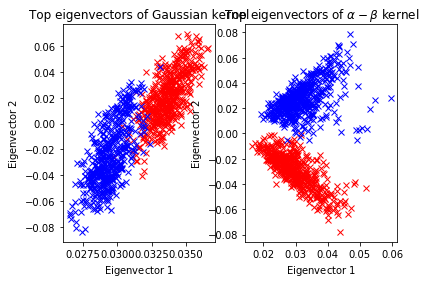

In [6]:
n = 1000

cs = [1/2,1/2]
k = len(cs) # number of classes

EEG_mat = scipy.io.loadmat('../datasets/EEG.mat')
init_data = EEG_mat['EEG_data']
init_labels = EEG_mat['EEG_labels']

data = init_data
labels = init_labels
init_n,p=np.shape(data)[1],np.shape(data)[0]

selected_labels=[2, 5] # selected digits: must be of size 'k'

# Data preprocessing
data = data/data.max()
mean_data = np.mean(data,axis=1).reshape(len(data),1)
data = np.mat(data-mean_data@np.ones((1,init_n)))

for i in range(init_n):
    data[:,i] = data[:,i]/np.linalg.norm(data[:,i])*np.sqrt(p)

selected_data = []
for i in range(len(selected_labels)):
    selected_data.append(data[:,[ x for x in range(init_n) if labels[x]==selected_labels[i] ] ])

X= np.zeros((p,n))
for i in range(k): # random data picking
    data = selected_data[i][:,np.random.permutation(np.shape(selected_data[i])[1])]
    X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=data[:,:int(n*cs[i])] 

P = np.eye(n) - np.ones((n,n))
X = X@P
XX=X.T@X

dist_matrix = (-2*XX+np.diag(XX).reshape(n,1)+np.diag(XX).reshape(1,n))/p
tau_estim = np.ones((1,n))@dist_matrix@np.ones((n,1))/n/(n-1)

K1 = np.exp(-dist_matrix)
K2 = (dist_matrix - tau_estim)**2

eigs_K1,V1 = np.linalg.eigh(K1)
eigs_K2,V2 = np.linalg.eigh(K2)
ind = np.argsort(eigs_K1)
V1 = V1[:,ind]
ind = np.argsort(eigs_K2)
V2 = V2[:,ind]

v1_1 = V1[:,-1]
v1_2 = V1[:,-2]

v2_1 = V2[:,-1]
v2_2 = V2[:,-2]

plt.figure()
plt.subplot(1,2,1)
plt.plot(v1_1[:int(n*cs[0])],v1_2[:int(n*cs[0])],'rx')
plt.plot(v1_1[int(n*cs[0]):],v1_2[int(n*cs[0]):],'bx')
plt.xlabel(r'Eigenvector $1$')
plt.ylabel(r'Eigenvector $2$')
plt.title(r'Top eigenvectors of Gaussian kernel')

plt.subplot(1,2,2)
plt.plot(v2_1[:int(n*cs[0])],v2_2[:int(n*cs[0])],'rx')
plt.plot(v2_1[int(n*cs[0]):],v2_2[int(n*cs[0]):],'bx')
plt.xlabel(r'Eigenvector $1$')
plt.ylabel(r'Eigenvector $2$')
plt.title(r'Top eigenvectors of $\alpha-\beta$ kernel')

_ = plt.show()


## FUNCTIONS

In [7]:
def spectral_clustering_perf(cs,K,nb_eigs):
    
    n = len(K)
    k = len(cs)
    ns = n*cs
    
    V = scipy.sparse.linalg.eigsh(K,nb_eigs,which='LA')[1]

    V_means=np.zeros( (k,nb_eigs) )
    for i in range(k):
        V_means[i,:]=np.mean(V[int(np.sum(ns[:i])):int(np.sum(ns[:i+1])),:],0)

    kmeans_output = sklearn.cluster.KMeans(n_clusters=k, init=V_means, n_init=1).fit_predict(V)

    vec=np.zeros(n)
    tmp=0
    perms = list(itertools.permutations(list(range(k))))
    for perm in perms:
        for i in range(k):
            vec[int(np.sum(ns[:i])):int(np.sum(ns[:i+1]))]=perm[i]

        if np.sum(kmeans_output==vec)>tmp:
            tmp=np.sum(kmeans_output==vec)
            best_vec=vec.copy()

    return 1- np.sum(best_vec==kmeans_output)/n 

## Performance of spectral clustering with properly scaling kernels

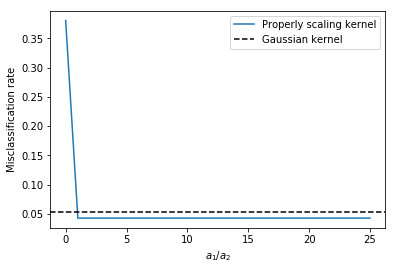

In [8]:
n = 512
cs = np.array([1/2,1/2])
k = len(cs) # number of classes

test_case = 'MNIST'

if test_case == 'MNIST':
    (init_data, init_labels), _ = mnist.load_data()
    idx_init_labels = np.argsort(np.array(init_labels))

    labels = init_labels[idx_init_labels]
    init_data = init_data[idx_init_labels,:,:]
    data = np.transpose(init_data.reshape(np.shape(init_data)[0],np.shape(init_data)[1]*np.shape(init_data)[2]))
    init_n,p=np.shape(data)[1],np.shape(data)[0]
    selected_labels=[1, 7] # selected digits: must be of size 'k'
    
if test_case == 'EEG':
    EEG_mat = scipy.io.loadmat('../datasets/EEG.mat')
    init_data = EEG_mat['EEG_data']
    init_labels = EEG_mat['EEG_labels']
    data = init_data
    labels = init_labels
    init_n,p=np.shape(data)[1],np.shape(data)[0]
    selected_labels=[1, 5] # selected digits: must be of size 'k'
    
# Data preprocessing
data = data/data.max()
mean_data=np.mean(data,axis=1).reshape(len(data),1)

norm2_data=0
for i in range(init_n):
    norm2_data+=1/init_n*np.linalg.norm(data[:,i]-mean_data)**2

data=np.mat((data-mean_data)/np.sqrt(norm2_data)*np.sqrt(p))

selected_data = []

for i in range(len(selected_labels)):
    selected_data.append(data[:,[ x for x in range(init_n) if labels[x]==selected_labels[i] ] ])

a1_over_a2_range = np.arange(0., 26.)
nb_average_loop = 10
nb_eigs = 2 

P = np.eye(n) - np.ones((n,n))/n

K_gauss_error = np.zeros((nb_average_loop,1));
K_proper_error = np.zeros((len(a1_over_a2_range),nb_average_loop));
    
for loop in range(nb_average_loop):
    
    X= np.zeros((p,n))
    for i in range(k): # random data picking
        data = selected_data[i][:,np.random.permutation(np.shape(selected_data[i])[1])]
        X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=data[:,:int(n*cs[i])] 
    
    X = X@P
    XX=X.T@X
    dist_matrix = (-2*XX+np.diag(XX).reshape(n,1)+np.diag(XX).reshape(1,n))/p

    K_gauss = np.exp(-dist_matrix/2)
    K_gauss_error[loop] = spectral_clustering_perf(cs,K_gauss,2)
    
    for range_index in range(len(a1_over_a2_range)):
        
        nu = 2
        a2 = np.sqrt( nu/(1+a1_over_a2_range[range_index]**2) )
        a1 = a1_over_a2_range[range_index]*a2
        
        f = lambda t : a2*(t**2-1)/np.sqrt(2) + a1*t
        K_proper = f(XX/np.sqrt(p))/np.sqrt(p)
        K_proper = K_proper - np.diag(np.diag(K_proper))
        
        K_proper_error[range_index,loop] =  spectral_clustering_perf(cs,K_proper,2)

plt.figure()
plt.plot(a1_over_a2_range,np.mean(K_proper_error,1), label=r'Properly scaling kernel')
plt.axhline(y=np.mean(K_gauss_error),xmin=0,xmax=25,c='k',ls='--', label=r'Gaussian kernel')
plt.legend()
plt.xlabel(r'$a_1/a_2$')
plt.ylabel(r'Misclassification rate');